In [1]:
# all imports
import importlib
import be_prediction
importlib.reload(be_prediction)
from be_prediction import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.metrics import mean_squared_error
import time
import psutil

# set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# parse data & build features
df = parse_mass_mas20("mass_1.mas20.txt")
X, y = make_features(df)

# create train/val/test split (10% test, 72% train, 18% val)
X_train, X_val, X_test, y_train, y_val, y_test = create_train_val_test_split(X.values, y, test_size=0.1, random_state=42)

# Start timing measurements
start_wall = time.time()
start_cpu = time.process_time() 
process = psutil.Process()
start_memory = process.memory_info().rss / 1024 / 1024  # MB

# A. NEURAL NETWORK ENSEMBLE TRAINING (Monte Carlo Cross Validation)
print("\nTraining an ensemble of 50 Feed Forward Neural Networks of shape [3, 64, 64, 1]...")
ensemble_pred_train, ensemble_pred_val, models, scaler, training_histories = train_nn_ensemble(
    X_train, X_val, y_train, y_val, n_models=50)

# End timing measurements
end_wall = time.time()
end_cpu = time.process_time()
end_memory = process.memory_info().rss / 1024 / 1024  # MB

# Generate test predictions using ensemble (the test data is never seen before)
print("\nGenerating ensemble predictions on test set...")
y_test_pred_nn = predict_ensemble_on_test(models, scaler, X_test)

# B. XGBOOST RESIDUALS TRAINING (Using Scaled Features)
print("\nTraining XGBoost on ensemble residuals...")

# Compute residuals on train and val sets (in MeV)
resid_train = y_train - ensemble_pred_train  
resid_val = y_val - ensemble_pred_val        

# Get SCALED features for XGBoost
X_train_scaled = scaler.transform(X_train)  # Use scaler fitted on train+val
X_val_scaled = scaler.transform(X_val)       
X_test_scaled = scaler.transform(X_test)    

# Train XGB
xgb_model = train_xgb_on_residuals(X_train_scaled, resid_train, X_val_scaled, resid_val)

# FINAL STACKED PREDICTIONS (Test Set Evaluation)
print("\nProducing final stacked predictions...")

# Predict residuals on test set
resid_pred_test = xgb_model.predict(X_test_scaled)

# Final stacked predictions: NN ensemble + XGBoost residual correction
y_test_pred_stacked = y_test_pred_nn + resid_pred_test

# COMPREHENSIVE EVALUATION (Single Test Set Evaluation)
print("\nFinal Model Evaluation...")
final_rmse, final_mae = evaluate_final_model(
    y_train, y_val, y_test,
    ensemble_pred_train, ensemble_pred_val, y_test_pred_nn,
    y_test_pred_stacked
)
# Get summary
print(f"FINAL PERFORMANCE ON HELD-OUT TEST SET:")
print(f"   RMSE: {final_rmse:.4f} keV")
print(f"   MAE:  {final_mae:.4f} keV")

Starting to parse from line 37
Parsed 3557 nuclei from mass_1.mas20.txt
Z range: 1 to 118
A range: 1 to 295
Created 3 features for 3557 nuclei
Features: ['Z', 'N', 'A']
Target range: -2.3 to 8.8 MeV
Data split:
  Train: 2560 samples (72.0%)
  Val:   641 samples (18.0%)
  Test:  356 samples (10.0%)

Training an ensemble of 50 Feed Forward Neural Networks of shape [3, 64, 64, 1]...

Training ensemble of 50 neural networks with Monte Carlo CV...
  Using BatchNorm (MC training set size: 2560)
  Total train+val: 3201, MC train: 2560, MC val: 641
  Training model 1/50...
Epoch 50, Train Loss: 0.65, Val Loss: 0.37
Epoch 50, Train Loss: 0.65, Val Loss: 0.37
Epoch 100, Train Loss: 0.56, Val Loss: 0.34
Epoch 100, Train Loss: 0.56, Val Loss: 0.34
Early stopping at epoch 105
    Model 1 MC validation RMSE: 567.94 keV (0.568 MeV)
    Trained on 2560 samples, validated on 641 samples
  Training model 2/50...
Early stopping at epoch 105
    Model 1 MC validation RMSE: 567.94 keV (0.568 MeV)
    Train

In [3]:
# Timing analysis results

# Calculate results
wall_time = end_wall - start_wall
cpu_time = end_cpu - start_cpu
memory_used = end_memory - start_memory
cpu_efficiency = (cpu_time / wall_time * 100) if wall_time > 0 else 0

# Display results
print(f"\nTRAINING TIME ANALYSIS:")
print(f"    Wall Clock Time: {wall_time:.1f}s ({wall_time/60:.1f} minutes)")
print(f"    CPU Time: {cpu_time:.1f}s ({cpu_time/60:.1f} minutes)")  
print(f"    CPU Efficiency: {cpu_efficiency:.1f}% (CPU time / Wall time)")
print(f"    Memory Used: {memory_used:.1f} MB")
print(f"\nPer Model Average:")
print(f"   Wall time per model: {wall_time/50:.1f}s")
print(f"   CPU time per model: {cpu_time/50:.1f}s")


TRAINING TIME ANALYSIS:
    Wall Clock Time: 978.6s (16.3 minutes)
    CPU Time: 7786.6s (129.8 minutes)
    CPU Efficiency: 795.7% (CPU time / Wall time)
    Memory Used: 65.0 MB

Per Model Average:
   Wall time per model: 19.6s
   CPU time per model: 155.7s


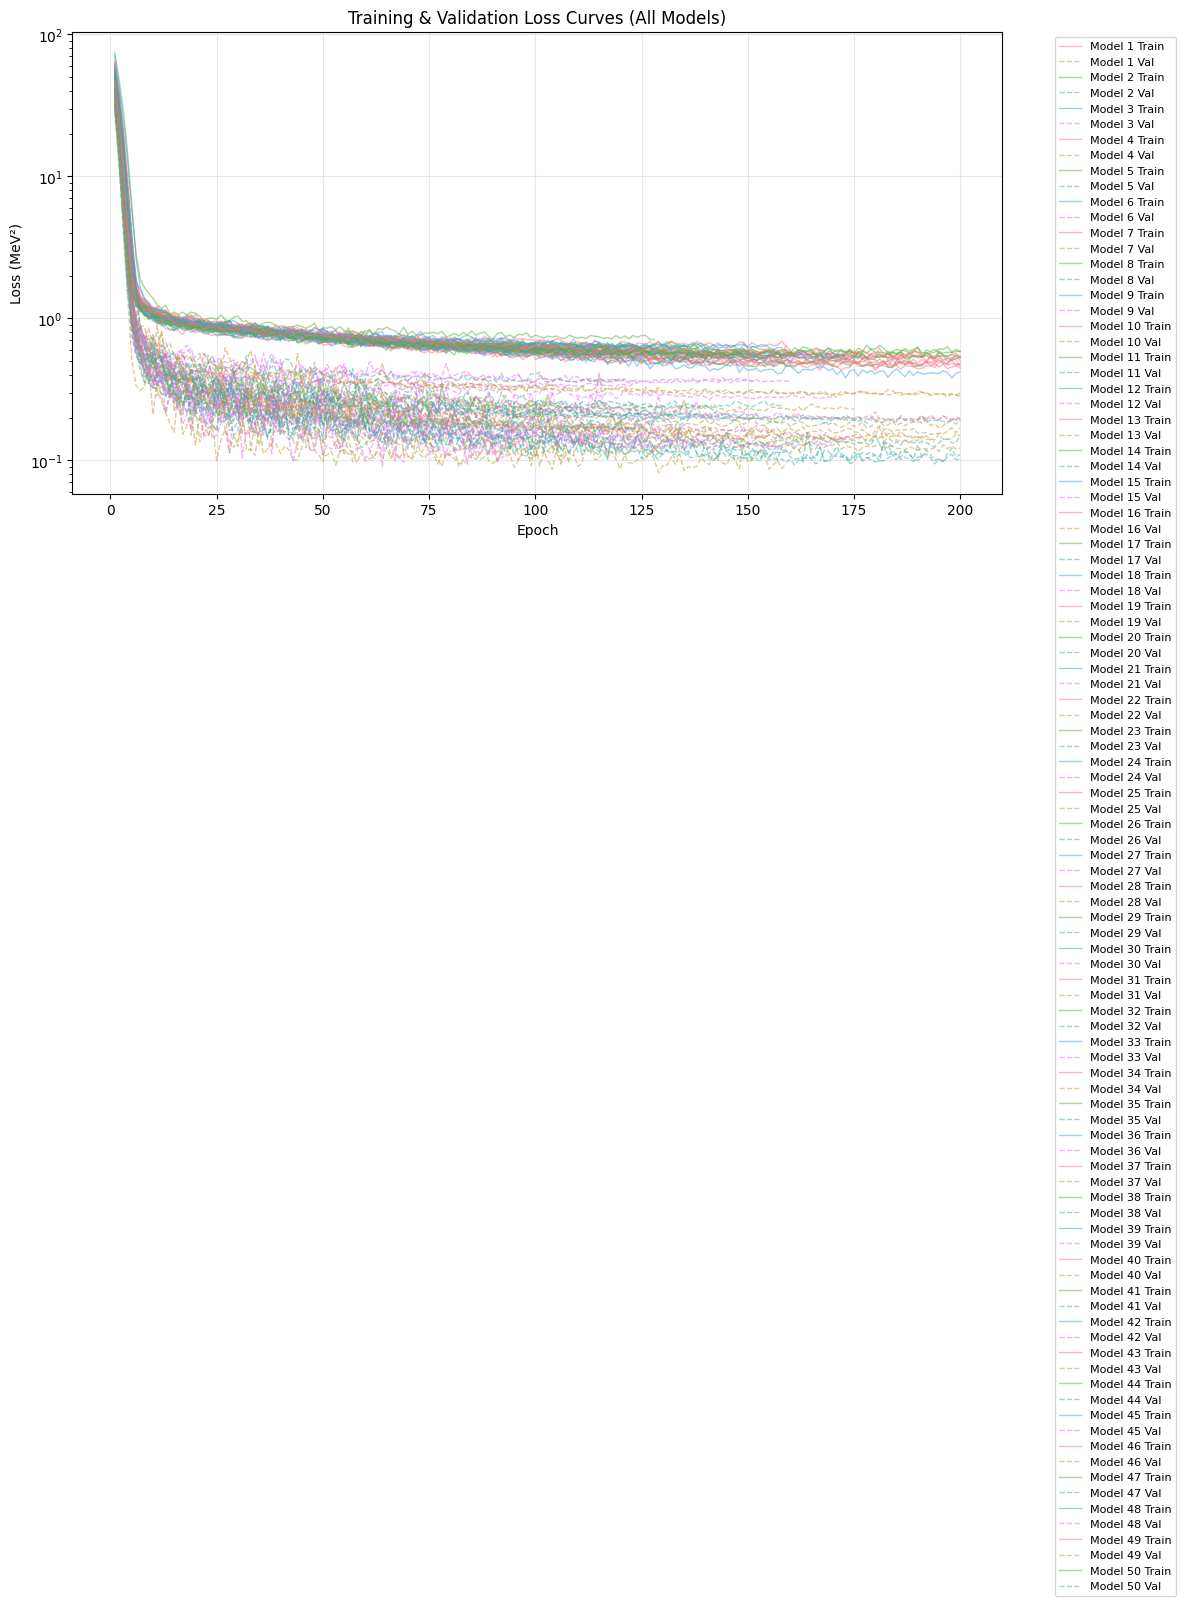

In [4]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
for i, history in enumerate(training_histories):
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], alpha=0.5, linewidth=1, label=f'Model {i+1} Train')
    ax.plot(epochs, history['val_loss'], alpha=0.5, linewidth=1, linestyle='--', label=f'Model {i+1} Val')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MeV²)')
ax.set_title('Training & Validation Loss Curves (All Models)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.show()


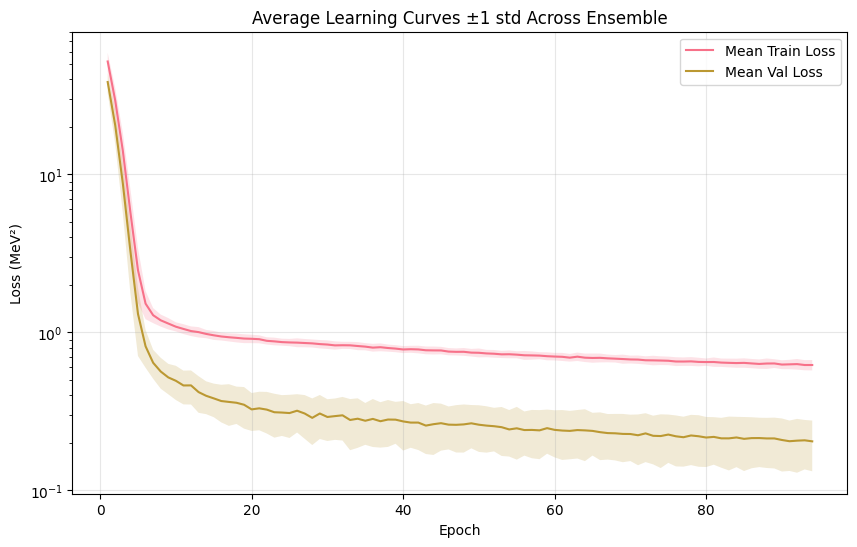

In [5]:
# Build aligned val losses
min_len = min(len(h['val_loss']) for h in training_histories)
val_losses_matrix = np.array([h['val_loss'][:min_len] for h in training_histories])
train_losses_matrix = np.array([h['train_loss'][:min_len] for h in training_histories])

mean_val = np.mean(val_losses_matrix, axis=0)
std_val = np.std(val_losses_matrix, axis=0)
mean_train = np.mean(train_losses_matrix, axis=0)
std_train = np.std(train_losses_matrix, axis=0)
epochs = range(1, min_len+1)

plt.figure(figsize=(10,6))
plt.plot(epochs, mean_train, label='Mean Train Loss')
plt.fill_between(epochs, mean_train-std_train, mean_train+std_train, alpha=0.2)
plt.plot(epochs, mean_val, label='Mean Val Loss')
plt.fill_between(epochs, mean_val-std_val, mean_val+std_val, alpha=0.2)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (MeV²)')
plt.title('Average Learning Curves ±1 std Across Ensemble')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


C:\Users\Tanishq\AppData\Local\Temp\ipykernel_24680\2211770927.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, len(models)+1)), y=val_train_ratios, ax=axes[1], palette="coolwarm")


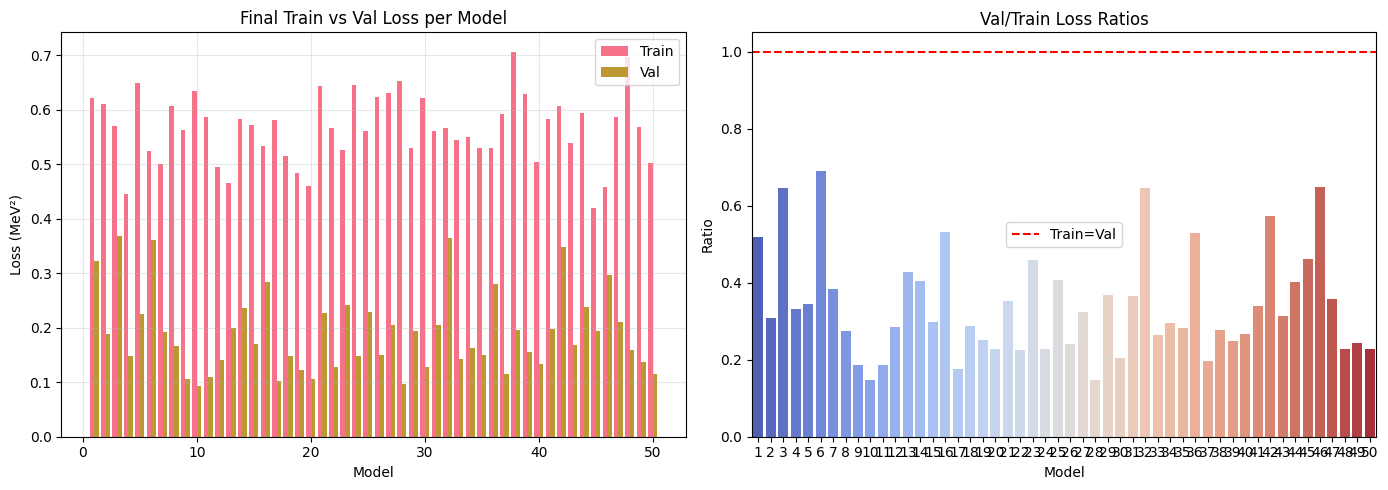

In [6]:
final_train_losses = [h['train_loss'][-1] for h in training_histories]
final_val_losses = [h['val_loss'][-1] for h in training_histories]
val_train_ratios = [v/t if t>0 else np.nan for v, t in zip(final_val_losses, final_train_losses)]

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Final train vs val losses
x = np.arange(1, len(models)+1)
axes[0].bar(x-0.2, final_train_losses, width=0.4, label="Train")
axes[0].bar(x+0.2, final_val_losses, width=0.4, label="Val")
axes[0].set_title("Final Train vs Val Loss per Model")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Loss (MeV²)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Val/Train ratios
sns.barplot(x=list(range(1, len(models)+1)), y=val_train_ratios, ax=axes[1], palette="coolwarm")
axes[1].axhline(1.0, color='r', linestyle='--', label="Train=Val")
axes[1].set_title("Val/Train Loss Ratios")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Ratio")
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Collect individual model predictions on validation set for bias-variance analysis
X_val_scaled = scaler.transform(X_val)
all_model_val_preds = []

for model in models:
    val_pred = predict_nn(model, X_val_scaled)
    all_model_val_preds.append(val_pred)

all_val_preds = np.array(all_model_val_preds)  # shape: (n_models, n_samples)
ensemble_mean_val = np.mean(all_val_preds, axis=0)

bias_sq = np.mean((ensemble_mean_val - y_val)**2)
variance = np.mean(np.var(all_val_preds, axis=0))

print("\nBias-Variance Decomposition (Validation):")
print(f"  Bias^2: {bias_sq:.6f} MeV²")
print(f"  Variance: {variance:.6f} MeV²")
print(f"  Total Error: {np.mean((y_val-ensemble_mean_val)**2):.6f} MeV²")
print(f"  Note: Bias^2 + Variance ≈ Total Error (ignoring noise)")

# Calculate individual model RMSEs on the SAME validation set (for fair comparison)
individual_rmses_on_common_val = []
for model_pred in all_model_val_preds:
    individual_rmse = math.sqrt(mean_squared_error(y_val, model_pred)) * 1000  # keV
    individual_rmses_on_common_val.append(individual_rmse)


Bias-Variance Decomposition (Validation):
  Bias^2: 0.279412 MeV²
  Variance: 0.008081 MeV²
  Total Error: 0.279412 MeV²
  Note: Bias^2 + Variance ≈ Total Error (ignoring noise)


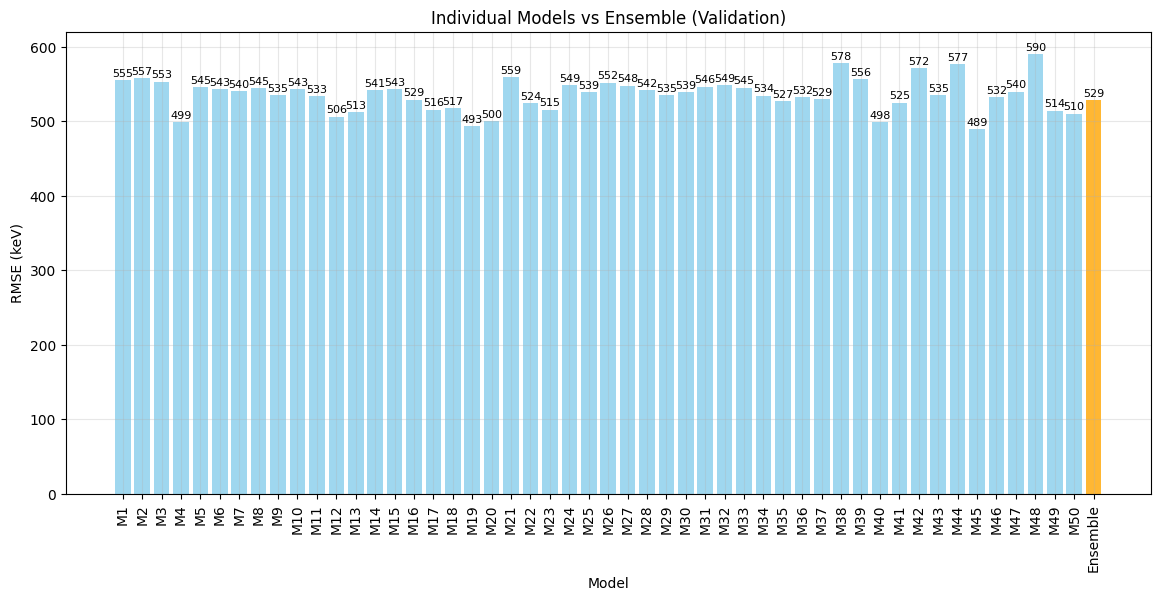

In [10]:
# Use the corrected individual RMSEs calculated on the same validation set
individual_rmses = individual_rmses_on_common_val  # keV (calculated on common val set)
ensemble_rmse_val = math.sqrt(mean_squared_error(y_val, ensemble_pred_val)) * 1000  # keV

x_pos = list(range(1, len(models)+1)) + [len(models)+1]
rmse_values = individual_rmses + [ensemble_rmse_val]
colors = ['skyblue'] * len(models) + ['orange']

plt.figure(figsize=(14,6))
bars = plt.bar(x_pos, rmse_values, color=colors, alpha=0.8)
plt.xlabel("Model")
plt.ylabel("RMSE (keV)")
plt.title("Individual Models vs Ensemble (Validation)")
plt.xticks(x_pos, [f"M{i+1}" for i in range(len(models))] + ["Ensemble"], rotation=90)
plt.grid(True, alpha=0.3)

for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2., value + 5, f"{value:.0f}", ha='center', fontsize=8)

plt.show()

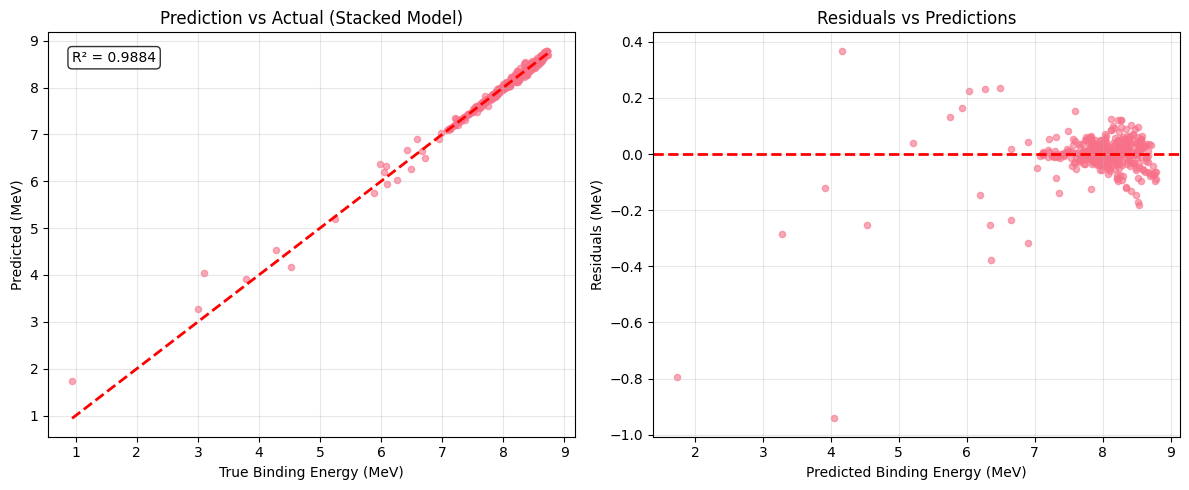

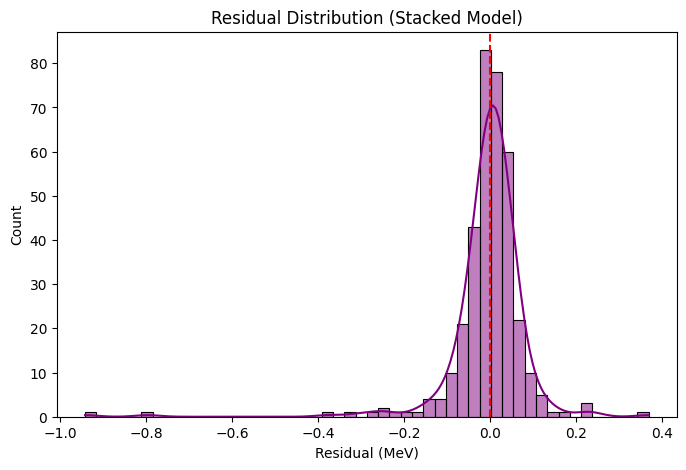

In [11]:
# Scatter plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_test_pred_stacked, alpha=0.6, s=20)
min_val = min(min(y_test), min(y_test_pred_stacked))
max_val = max(max(y_test), max(y_test_pred_stacked))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel("True Binding Energy (MeV)")
plt.ylabel("Predicted (MeV)")
plt.title("Prediction vs Actual (Stacked Model)")
plt.grid(True, alpha=0.3)

correlation = np.corrcoef(y_test, y_test_pred_stacked)[0, 1]
plt.text(min_val, max_val, f"R² = {correlation**2:.4f}", ha="left", va="top",
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Residual plot
plt.subplot(1,2,2)
residuals = y_test - y_test_pred_stacked
plt.scatter(y_test_pred_stacked, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted Binding Energy (MeV)")
plt.ylabel("Residuals (MeV)")
plt.title("Residuals vs Predictions")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residual distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Residual (MeV)")
plt.ylabel("Count")
plt.title("Residual Distribution (Stacked Model)")
plt.show()


In [12]:
avg_individual_rmse = np.mean(individual_rmses)
improvement = (avg_individual_rmse - ensemble_rmse_val) / avg_individual_rmse * 100
print("FINAL ANALYSIS SUMMARY:")
print(f"Average individual RMSE (on common val set): {avg_individual_rmse:.2f} keV")
print(f"Ensemble RMSE (on same val set): {ensemble_rmse_val:.2f} keV")
print(f"Ensemble improvement: {improvement:.1f}%")
print(f"Stacked Test RMSE: {final_rmse:.2f} keV ({final_rmse/1000:.4f} MeV)")
print(f"Stacked Test MAE: {final_mae:.2f} keV ({final_mae/1000:.3f} MeV)")
print(f"\nNote: Both individual and ensemble RMSEs calculated on the same validation set for fair comparison.")

FINAL ANALYSIS SUMMARY:
Average individual RMSE (on common val set): 535.75 keV
Ensemble RMSE (on same val set): 528.59 keV
Ensemble improvement: 1.3%
Stacked Test RMSE: 94.38 keV (0.0944 MeV)
Stacked Test MAE: 48.17 keV (0.048 MeV)

Note: Both individual and ensemble RMSEs calculated on the same validation set for fair comparison.
